# Import Library Dependencies

In [11]:
import numpy as np
import cv2 as cv
import os
import re
import math
import time
import pandas as pd

from matplotlib import pyplot as plt

# Preprocessing Steps:

In [12]:
def img_Resize(img_path):
    if img_path:
        image = cv.imread(img_path)
        
        width = 300
        height = 300
        
        # new size
        new_size = (width, height)

        # resize image
        img_resize = cv.resize(image, new_size)
    else:
        print("path not found")

    return img_resize

In [13]:
def img_Preprocessing(img):
    
    image = img_Resize(img)

    # getting lab colorspace
    img = cv.cvtColor(image, cv.COLOR_BGR2Lab)
    
    # smoothing gaussian blur
    img_smoothing = cv.GaussianBlur(img, (3,3),0)

    # splitting channel L a b
    img_L, img_A, img_B = cv.split(img_smoothing)

    # otsu treshold segmentation
    ret, thresh = cv.threshold(img_B, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # noise removal
    kernel_dilatasi = np.ones((5, 5), np.uint8)
    kernel_erosi = np.ones((3, 3), np.uint8)
    img_dilatasi = cv.dilate(thresh, kernel_dilatasi, iterations=5)
    img_erosi = cv.erode(img_dilatasi, kernel_erosi, iterations=9)

    img_result = cv.bitwise_and(image, image, mask=img_erosi)
    
    return img_result

# Feature Extraction

## Color Transformations

### RGB to CIELab

In [21]:
def rgb2lab(inputColor):
    num = 0
    RGB = [0, 0, 0]

    for value in inputColor:
        value = float(value) / 255.0

        if value <= 0.04045:
            value = value / 12.92
            
        else:
            value = ((value + 0.055) / 1.055) ** 2.4

        RGB[num] = value
        num = num + 1

    XYZ = [0, 0, 0]
    
    M = [[0.4124564, 0.3575761, 0.1804375],
         [0.2126729, 0.7151522, 0.0721750],
         [0.0193339, 0.1191920, 0.9503041]]
    
    X, Y, Z = np.dot(M, RGB)
    
    XYZ[0] = X / 0.950456         
    XYZ[1] = Y / 1.00         
    XYZ[2] = Z / 1.088754      
    
    num = 0
    for t in XYZ:

        if t > 0.008856:
            t = t ** (0.3333333333333333)
        else:
            t = (7.787 * t) + (16 / 116)

        XYZ[num] = t
        num = num + 1

    Lab = [0, 0, 0]

    L = (116 * XYZ[1]) - 16 if XYZ[1] > 0.008856 else 903.3 * XYZ[1]
    a = 500 * (XYZ[0] - XYZ[1])
    b = 200 * (XYZ[1] - XYZ[2])

    Lab[0] = L
    Lab[1] = a
    Lab[2] = b

    Lab = np.array(Lab)

    return Lab

In [22]:
test = rgb2lab([215,172,131])
print(test)

[73.28080662 10.20779113 27.05046045]


### RGB to HSV

In [23]:
def rgb2hsv(inputColor):
    num = 0
    RGB = [0, 0, 0]
    
    for value in inputColor:
        value = float(value) / 255.0
        
        RGB[num] = value
        num = num + 1
    
    Cmax = max(RGB)
    Cmin = min(RGB)
    
    df = Cmax - Cmin
    
    HSV = [0, 0, 0]
    
    if df == 0:
        H = 0
    elif Cmax == RGB[0]:
        H = (60 * ((RGB[1]-RGB[2])/df) + 360) % 360
    elif Cmax == RGB[1]:
        H = (60 * ((RGB[2]-RGB[0])/df) + 120) % 360
    elif Cmax == RGB[2]:
        H = (60 * ((RGB[0]-RGB[1])/df) + 240) % 360
    if Cmax == 0:
        S = 0
    else:
        S = (df/Cmax) * 100
    V = Cmax * 100
    
    HSV[0] = H
    HSV[1] = S
    HSV[2] = V
    
    HSV = np.array(HSV)
    
    return HSV

In [9]:
test = rgb2hsv([202,46,69])
print(test)

[351.15384615  77.22772277  79.21568627]


### Main Color Transformation Function

In [19]:
def colorConversion(inputImage, colorspace=1):
    height = inputImage.shape[0]
    width = inputImage.shape[1]
    channels = inputImage.shape[2]

    new_image = np.zeros((height, width, channels), np.uint8)

    if colorspace:
        for pixel_Y in range(0, height):
            for pixel_X in range(0, width):
                new_image[pixel_Y,pixel_X] = rgb2lab(inputImage[pixel_Y,pixel_X])
    else:
        for pixel_Y in range(0, height):
            for pixel_X in range(0, width):
                new_image[pixel_Y,pixel_X] = rgb2hsv(inputImage[pixel_Y,pixel_X])

    return new_image[:,:,0], new_image[:,:,1], new_image[:,:,2]

## COLOR MOMENT Extraction

In [2]:
def CMoment_mean(channel):
    sum_pixels = 0
    
    height = channel.shape[0]
    width = channel.shape[1]
    
    for pixel_Y in range(0, height):
        for pixel_X in range(0, width):
            pixel = channel[pixel_Y, pixel_X]
            sum_pixels += pixel
    
    mean = sum_pixels / (height * width)
    
    return mean

def CMoment_stDev(channel, mean):
    sum_P_mean = 0
    
    height = channel.shape[0]
    width = channel.shape[1]
    
    for pixel_Y in range(0, height):
        for pixel_X in range(0, width):
            pixel = channel[pixel_Y, pixel_X]
            sum_P_mean += math.pow((pixel-mean),2)
    
    stDev = math.sqrt(sum_P_mean)
    
    return stDev

def CMoment_skewness(channel, mean, stDev):
    height = channel.shape[0]
    width = channel.shape[1]
    
    numerator = 0
    denumerator = height * width * math.pow(stDev,3)
    
    for pixel_Y in range(0, height):
        for pixel_X in range(0, width):
            pixel = channel[pixel_Y, pixel_X]
            numerator += math.pow((pixel-mean),3)
            
    skewness = numerator / denumerator
    
    return skewness

## Local Binary Pattern for Texture Extraction

In [28]:
def LocalBinaryPattern(inputImage):
    height = inputImage.shape[0]
    width = inputImage.shape[1]
    
    lbp_image = np.zeros((height, width), np.uint8)
    img_gray = cv.cvtColor(inputImage, cv.COLOR_BGR2GRAY)
    
    P_neighbours = [(-1,-1),(-1,0),(-1,1),(0,1),(1,1),(1,0),(1,-1),(0,-1)]
    
    for i in range(1, height-1):
        for j in range(1, width-1):
            binary = 0
            centerPixel = img_gray[i][j]
            for X in range(len(P_neighbours)):
                P = P_neighbours[X]
                value = 0 if img_gray[i+P[0]][j+P[1]] > centerPixel else 1
                binary += math.pow(2, (len(P_neighbours)-1)-X) * value
                
            lbp_image[i][j] = binary
    
    histogram = plt.hist(lbp_image.ravel(),8,[0,255])
    LBP = histogram[0]
    
    return LBP

# MAIN

[INFO] Found 540 files in dataset_kue directory
3036.030114889145


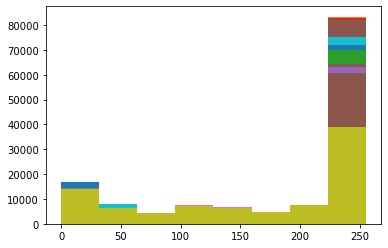

In [29]:
if __name__ == "__main__":
    start = time.time()
    folder_path = 'dataset_kue'
    
    data = []
    output = []
    
    if folder_path:
        print("[INFO] Found", len(os.listdir(folder_path)), "files in", folder_path, "directory")
        for fname in sorted(os.listdir(folder_path)):
            if not fname.startswith('.'):
                img = os.path.join(folder_path, fname)

                code = fname[0:3]
                    
                label = re.search('_(.+?) ', fname, flags=re.IGNORECASE).group(1)
                    
                # preprocessing
                img_preprocessed = img_Preprocessing(img)
                    
                img_L, img_a, img_b = colorConversion(img_preprocessed, colorspace=1)
                img_H, img_S, img_V = colorConversion(img_preprocessed, colorspace=0)
                    
                # feature extraction
                mean_L = CMoment_mean(img_L)
                mean_a = CMoment_mean(img_a)
                mean_b = CMoment_mean(img_b)
                stDev_L = CMoment_stDev(img_L, mean_L)
                stDev_a = CMoment_stDev(img_a, mean_a)
                stDev_b = CMoment_stDev(img_b, mean_b)
                skewness_L = CMoment_skewness(img_L, mean_L, stDev_L)
                skewness_a = CMoment_skewness(img_a, mean_a, stDev_a)
                skewness_b = CMoment_skewness(img_b, mean_b, stDev_b)
                mean_H = CMoment_mean(img_H)
                mean_S = CMoment_mean(img_S)
                mean_V = CMoment_mean(img_V)
                stDev_H = CMoment_stDev(img_H, mean_H)
                stDev_S = CMoment_stDev(img_S, mean_S)
                stDev_V = CMoment_stDev(img_V, mean_V)
                skewness_H = CMoment_skewness(img_H, mean_H, stDev_H)
                skewness_S = CMoment_skewness(img_S, mean_S, stDev_S)
                skewness_V = CMoment_skewness(img_V, mean_V, stDev_V)
                
                LBP = LocalBinaryPattern(img_preprocessed)
                
                data
                data = [code, label, mean_L, mean_a, mean_b, stDev_L, stDev_a, stDev_b,
                        skewness_L, skewness_a, skewness_b, 
                        mean_H, mean_S, mean_V, stDev_H, stDev_S, stDev_V,
                        skewness_H, skewness_S, skewness_V, 
                        LBP[0], LBP[1], LBP[2], LBP[3], LBP[4], LBP[5], LBP[6], LBP[7]]
                
                output.append(data)
    
    df_features = pd.DataFrame(output, columns=['code','label citra','Mean_L', 'Mean_a', 'Mean_b','StDev_L', 'StDev_a','StDev_b','skewness_L', 'skewness_a', 'skewness_b',
                                               'mean_H', 'mean_S', 'mean_V', 'stDev_H', 'stDev_S', 'stDev_V', 'skewness_H', 'skewness_S', 'skewness_V',
                                               'LBP_1','LBP_2','LBP_3','LBP_4','LBP_5','LBP_6','LBP_7','LBP_8'])
    else:
        print("path not found")
    end = time.time()
    
    exe_time = end - start
    print(exe_time)

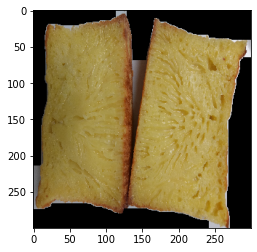

In [30]:
image = cv.cvtColor(img_preprocessed, cv.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

In [31]:
df_features

,code,label citra,Mean_L,Mean_a,Mean_b,StDev_L,StDev_a,StDev_b,skewness_L,skewness_a,...,skewness_S,skewness_V,LBP_1,LBP_2,LBP_3,LBP_4,LBP_5,LBP_6,LBP_7,LBP_8
0,000,WingkoKotak,12.340933,18.462644,62.139444,6237.379322,18254.070023,29205.586109,5.446225e-08,1.300268e-07,...,4.178870e-08,3.798407e-08,6158.0,2351.0,2083.0,2927.0,2454.0,2258.0,3007.0,68762.0
1,000,WingkoKotak,15.788778,21.593322,67.683333,7452.308412,20222.298044,30129.257824,4.637950e-08,1.148911e-07,...,4.294166e-08,3.287885e-08,7979.0,2469.0,1989.0,2873.0,2509.0,2130.0,2856.0,67195.0
2,000,WingkoKotak,15.515944,20.547722,66.441600,7391.028286,19690.161630,29902.027775,4.684670e-08,1.191547e-07,...,4.327935e-08,3.362522e-08,7853.0,2497.0,1869.0,2813.0,2471.0,2078.0,2785.0,67634.0
3,000,WingkoKotak,15.579944,19.682244,66.747289,7526.366374,19297.360825,30220.428692,4.853487e-08,1.226282e-07,...,4.725852e-08,3.502187e-08,7516.0,2201.0,2038.0,2635.0,3058.0,2118.0,3298.0,67136.0
4,000,WingkoKotak,15.576378,18.308733,66.534778,7535.824771,18600.479444,30195.258090,4.850485e-08,1.288483e-07,...,4.763655e-08,3.509377e-08,7502.0,2247.0,2007.0,2467.0,3133.0,2049.0,3267.0,67328.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,033,BikaAmbon,18.205767,82.161200,83.993989,7354.237582,34408.426487,33532.376083,2.477985e-08,2.532294e-08,...,2.617710e-08,2.245674e-08,8139.0,3905.0,2111.0,3726.0,3182.0,2169.0,3627.0,63141.0
535,033,BikaAmbon,21.210344,95.165967,93.708611,7802.775338,35564.572118,34196.861834,1.676305e-08,1.647069e-08,...,1.850826e-08,1.542462e-08,8512.0,3876.0,2404.0,4508.0,3457.0,2437.0,3954.0,60852.0
536,033,BikaAmbon,39.834767,161.190567,173.282567,7566.875697,34049.442324,31409.779163,-2.652973e-08,-2.595014e-08,...,-2.355011e-08,-3.211519e-08,14479.0,6467.0,4408.0,7384.0,6742.0,4652.0,7713.0,38155.0
537,033,BikaAmbon,39.101411,158.046344,170.055000,7653.108742,34324.757912,31933.543583,-2.454082e-08,-2.381542e-08,...,-2.144643e-08,-2.992909e-08,14385.0,6459.0,4287.0,7229.0,6417.0,4664.0,7453.0,39106.0


In [14]:
# df_features.to_excel("Daftar_Fitur_Citra.xlsx", sheet_name='Sheet_name_1') 
# df_features.to_csv('Daftar_Fitur_Citra.csv')